https://bit.ly/FEML-13-cluster

# Кластеризация & метрики качества

In [ ]:
import numpy as np

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 6)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Данные

в sklearn.datasets есть разные наборы данных, можно выбрать другие

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

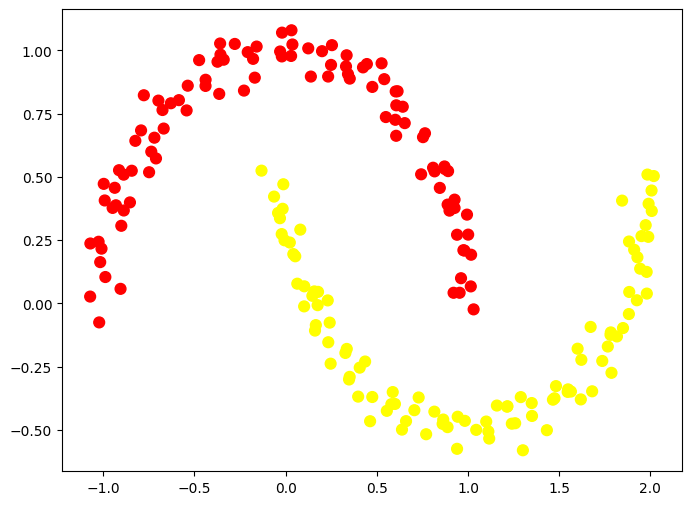

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', s=60);

приведём данные по обеим осям к нормальному распределению

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.mean(axis=0), X_scaled.std(axis=0)

(array([ 1.37667655e-16, -1.23789867e-16]), array([1., 1.]))

форма осталась, но диапазоны выровнялись:

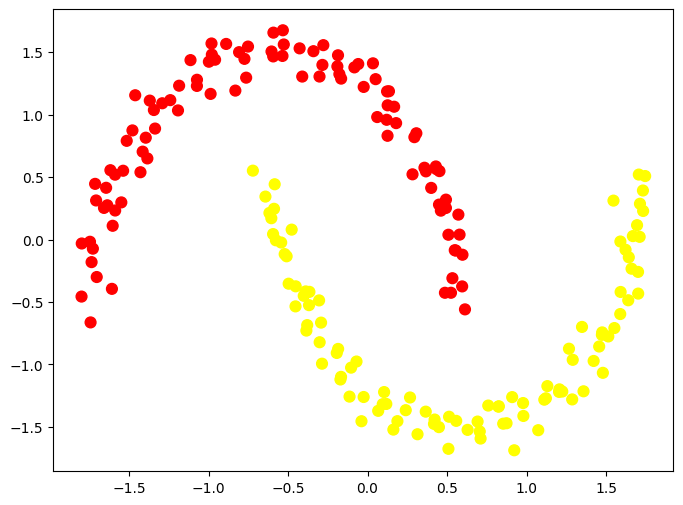

In [ ]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='autumn', s=60);

### Кластеризация

теперь кластеризуем с помощью различных методов

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [ ]:
algorithms = [
    KMeans(n_clusters=2),
    AgglomerativeClustering(n_clusters=2),
    DBSCAN()
]

сделаем случайное предсказание

In [ ]:
clusters_random = np.random.randint(low=0, high=2, size=len(X))

и функцию-заготовку, которая считает 2 метрики качества и генерирует заголовки для графиков

In [ ]:
def get_descr(algo_name, y, y_pred, X):
    ari = adjusted_rand_score(y, y_pred)
    sil = silhouette_score(X, y_pred)
    return f"{algo_name}\nARI {ari:.2f}\nSilhouette {sil:.2f}"

проследите за ростом ARI и за падением Silhouette (хотя этот показатель по своему назначению тоже должен расти):

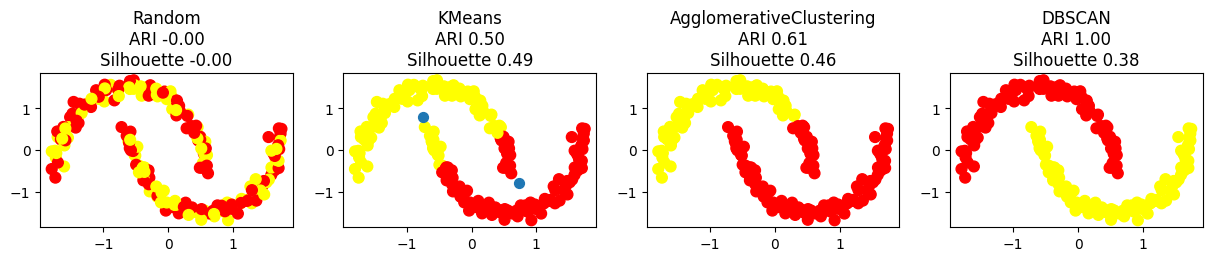

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 2))
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_random, cmap='autumn', s=60)
axes[0].set_title(get_descr("Random", y, clusters_random, X_scaled))

for ax, algorithm in zip(axes[1:], algorithms):
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=60)
    ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))

    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

## Подбор количества кластеров для KMeans

KMeans минимизирует сумму квадратов расстояний объектов классов до их центроидов. В обученном классификаторе это значение находится в поле inertia_

Посчитаем значения inertia при разном количестве кластеров. Они объективно стремятся к нулю с ростом числа кластеров (предельный случай: каждый объект - кластер, расстояние = 0)

In [ ]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled)
    k_inertia.append(clf_kmeans.inertia_)

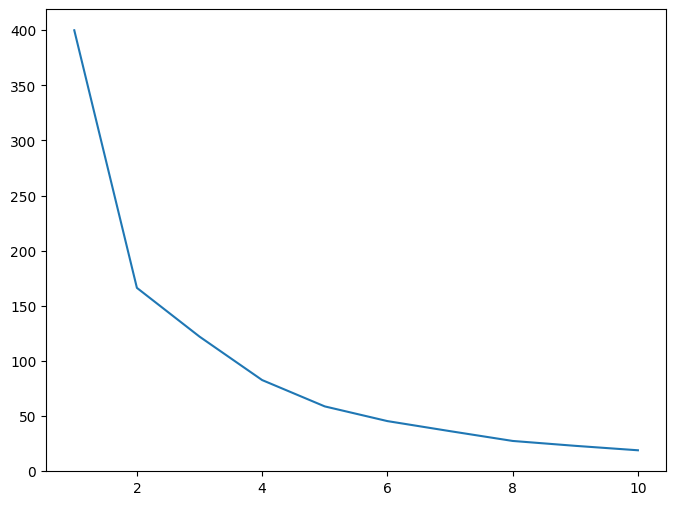

In [ ]:
plt.plot(ks, k_inertia);

Как подобрать оптимальное значение? Будем на каждом шаге смотреть изменение inertia, и в тот момент, когда оно резко замедлится (относительно предыдущего изменения) мы и остановимся

Для начала считаем сами изменения

$${inertia_{k+1}-inertia_{k}}$$

In [ ]:
diff = np.diff(k_inertia)

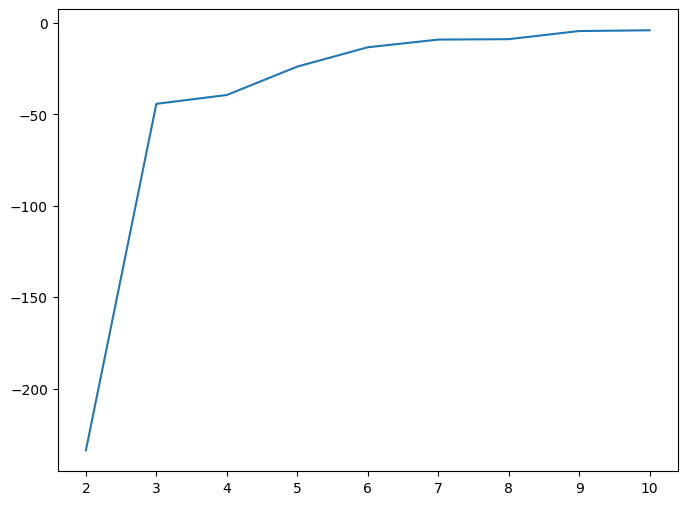

In [ ]:
plt.plot(ks[1:], diff);

Теперь можно найти оптимальное число кластеров по этой формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [ ]:
diff[1:]

array([-44.24847001, -39.43570028, -23.89306683, -13.33118872,
        -9.12225907,  -8.89119257,  -4.44123437,  -4.02744822])

In [ ]:
diff[:-1]

array([-233.76694672,  -44.24847001,  -39.43570028,  -23.89306683,
        -13.33118872,   -9.12225907,   -8.89119257,   -4.44123437])

In [ ]:
diff_r = diff[1:] / diff[:-1]

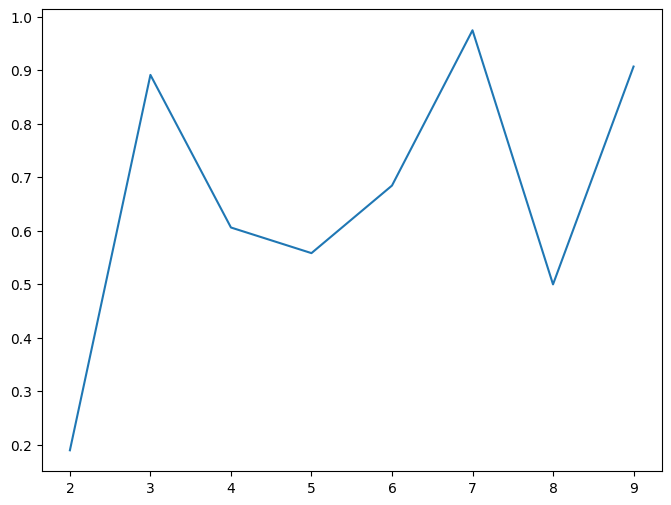

In [ ]:
plt.plot(ks[1:-1], diff_r);

In [ ]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

## Дендограмма

https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

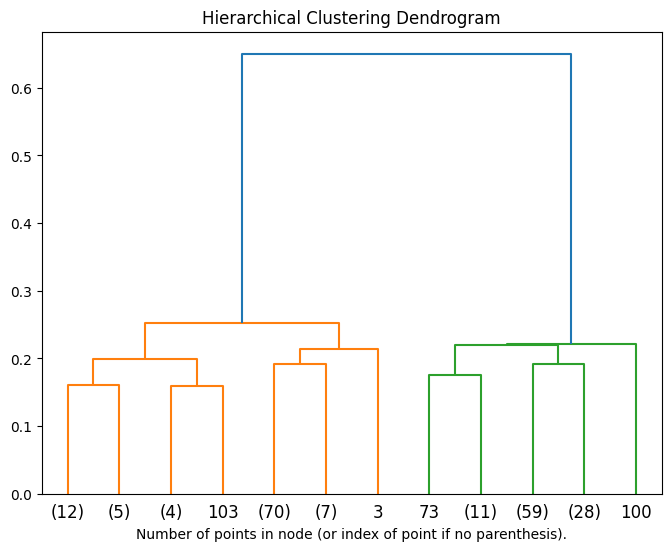

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(X_scaled)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

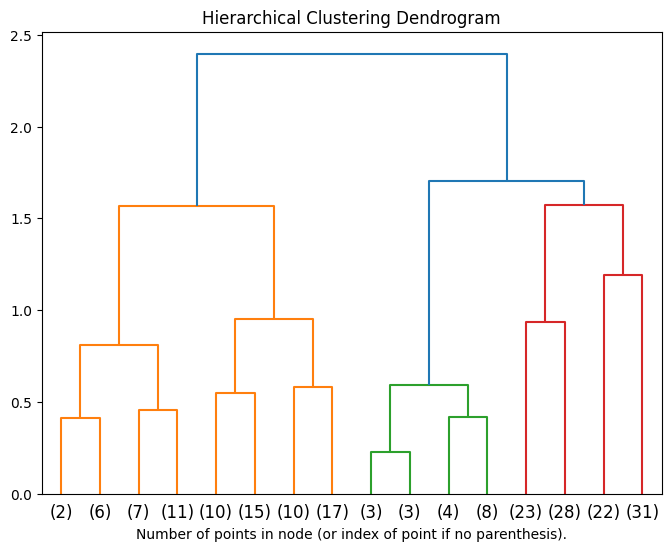

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(X_scaled)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

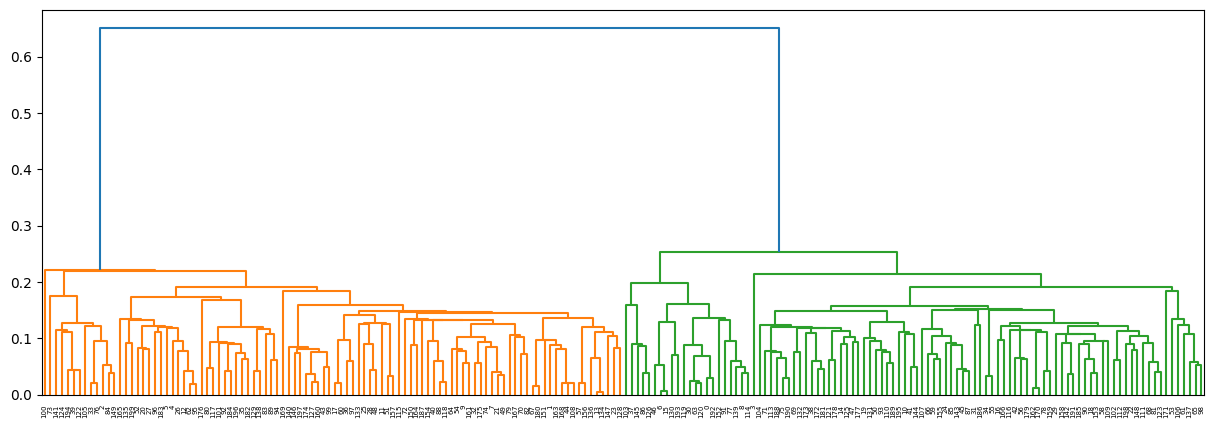

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(X_scaled)

Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(15,5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

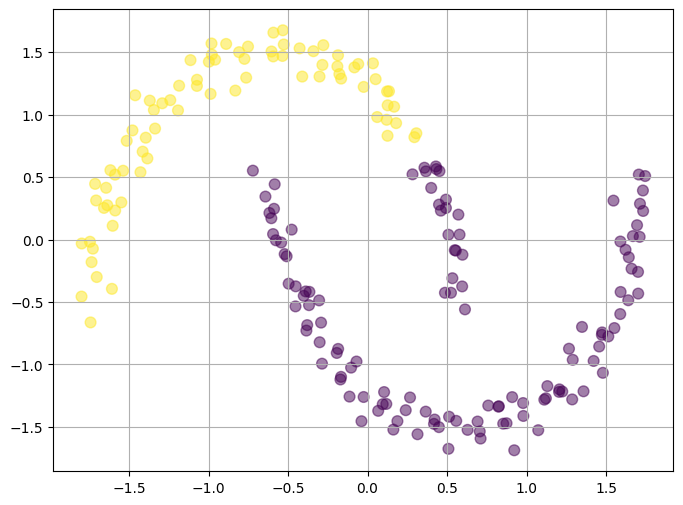

In [ ]:
model = AgglomerativeClustering(n_clusters=2, linkage='ward')

preds = model.fit_predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=60, c=preds, alpha=0.5)
plt.grid()

In [ ]:
centoid_1 = np.mean(X_scaled[preds == 1], axis=0)
centoid_0 = np.mean(X_scaled[preds == 0], axis=0)

centroids = np.vstack([centoid_0, centoid_1])
centroids

array([[ 0.55974769, -0.61028273],
       [-0.8755028 ,  0.95454478]])

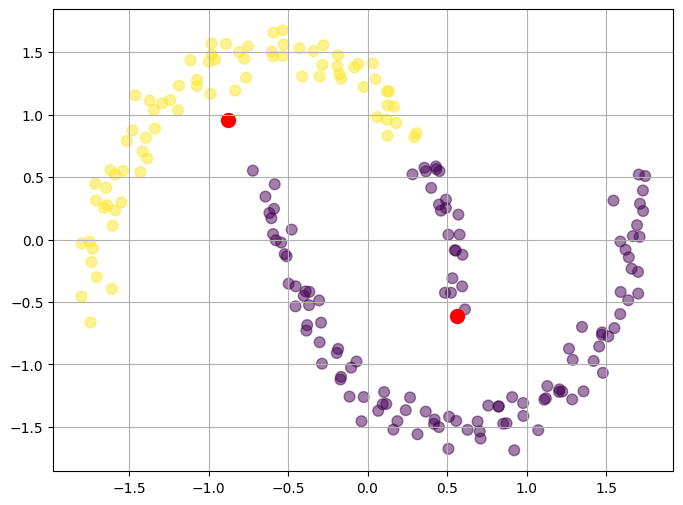

In [ ]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=60, c=preds, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100)
plt.grid()

## DBSCAN

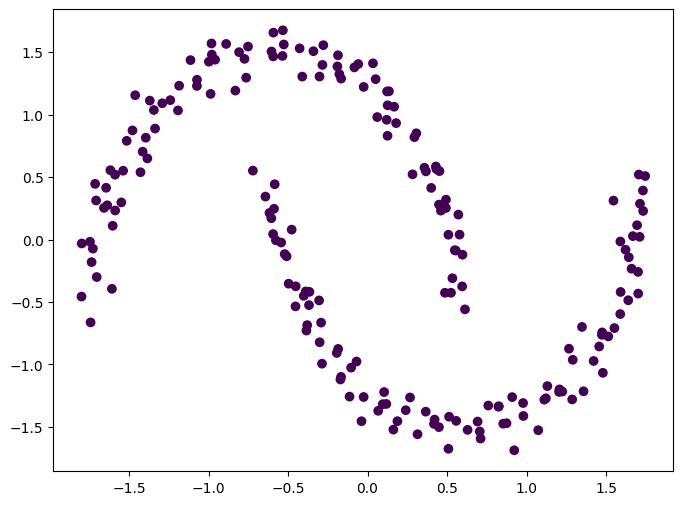

In [ ]:
scan_moons = DBSCAN(eps=1)
preds = scan_moons.fit_predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=preds)
plt.show()

In [ ]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

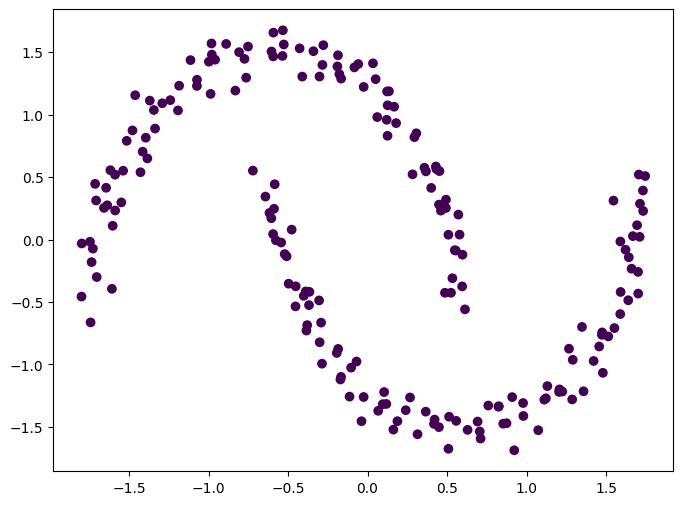

In [ ]:
scan_moons = DBSCAN(eps=0.01)# указываем eps
preds = scan_moons.fit_predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=preds)
plt.show()

In [ ]:
preds

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

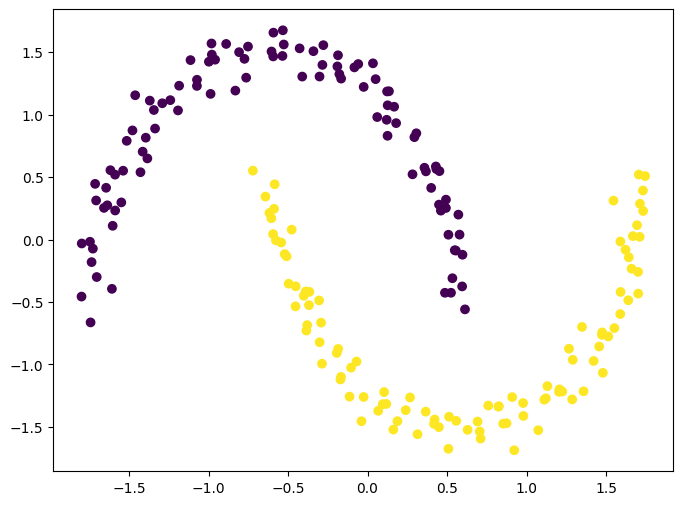

In [ ]:
scan_moons = DBSCAN(eps=0.5) # путем подбора правильного eps приходим к верному кол-ву кластеров
preds = scan_moons.fit_predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=preds)
plt.show()

In [ ]:
centoid_1 = np.mean(X_scaled[preds == 1], axis=0)
centoid_0 = np.mean(X_scaled[preds == 0], axis=0)

centroids = np.vstack([centoid_0, centoid_1])
centroids

array([[-0.57552068,  0.77174027],
       [ 0.57552068, -0.77174027]])

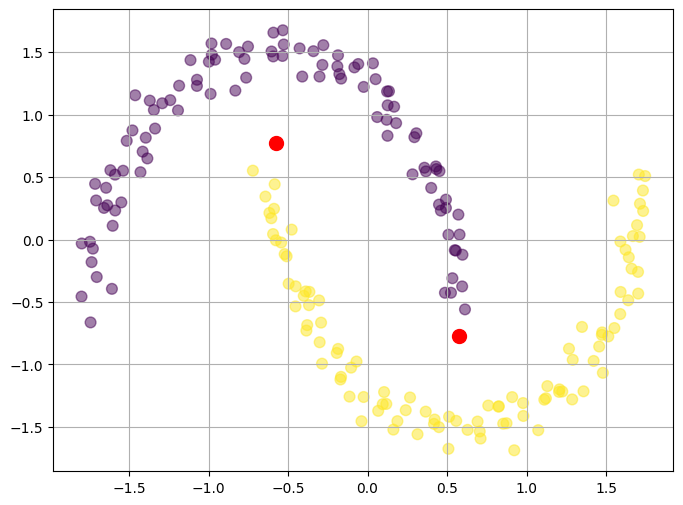

In [ ]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=60, c=preds, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100)
plt.grid()

# Пример

Визуализация набора данных MNIST из [статьи](https://habr.com/ru/company/ods/blog/325654/)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')
    plt.show()

In [ ]:
from sklearn import datasets


digits = datasets.load_digits()
X = digits.data
y = digits.target

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
y[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
X.shape

(1797, 64)

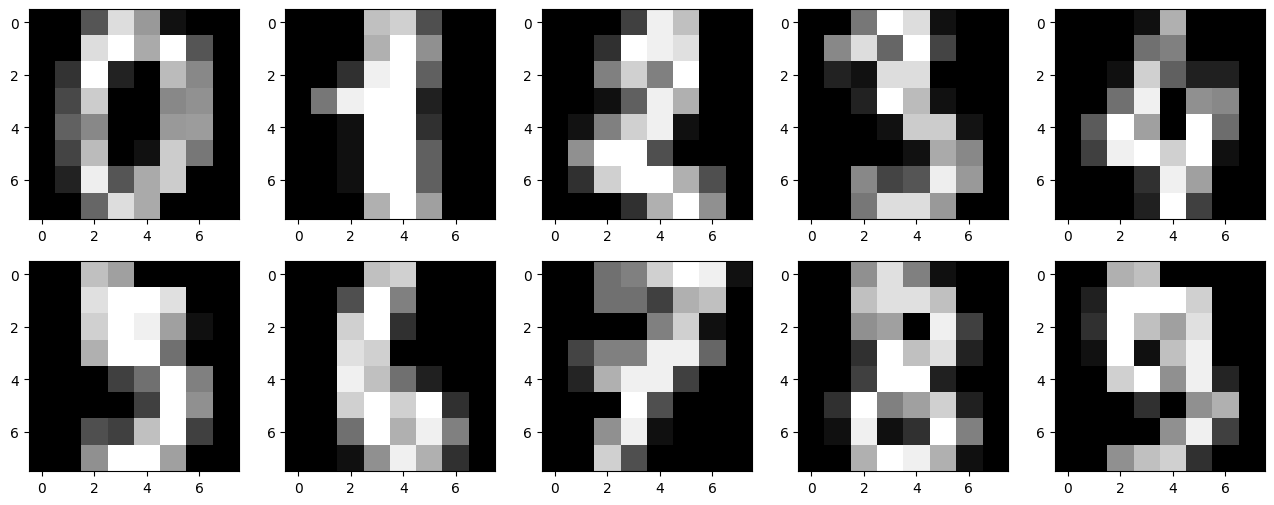

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray')

**PCA**

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(1797, 2)

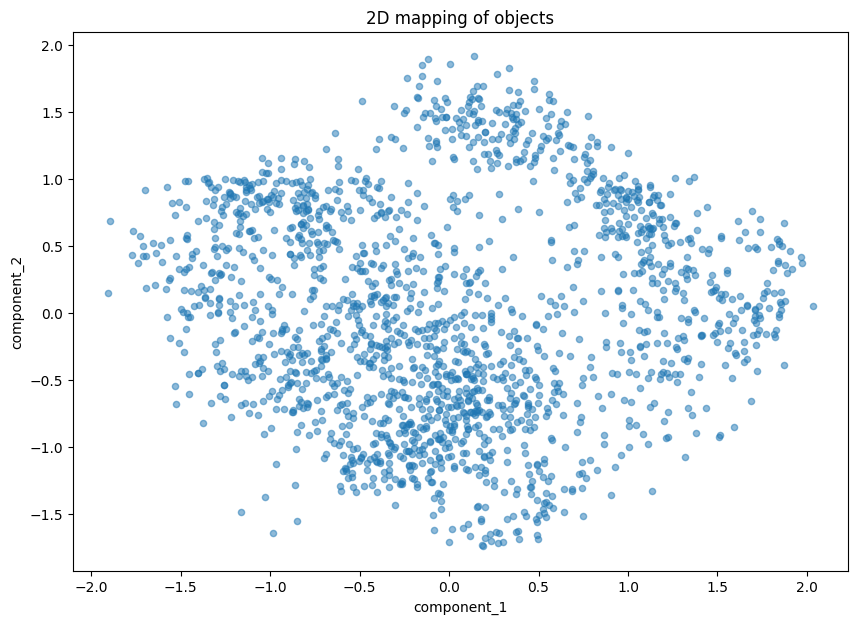

In [ ]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_reduced = pd.DataFrame(data=X_reduced, columns=colnames)
components_X_reduced.head()

display_components_in_2D_space(components_X_reduced)

**TSNE**

In [ ]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=17, perplexity=25)

X_tsne = tsne.fit_transform(X)

CPU times: user 24.4 s, sys: 150 ms, total: 24.6 s
Wall time: 16.1 s


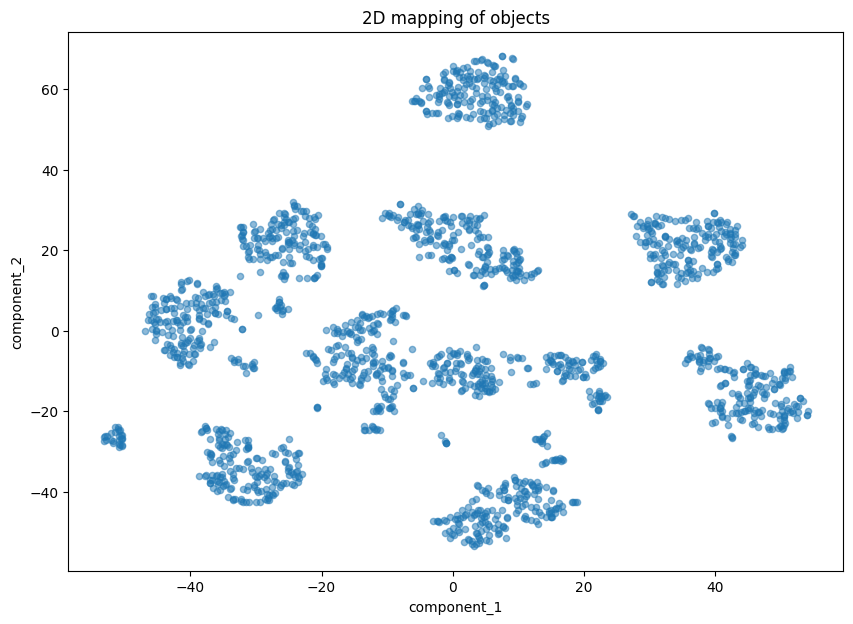

In [ ]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_tsne = pd.DataFrame(data=X_tsne, columns=colnames)
components_X_tsne.head()

display_components_in_2D_space(components_X_tsne)

**KMeans**

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
labels_clast = kmeans.fit_predict(X)
labels_clast = pd.Series(labels_clast, name='clusters')

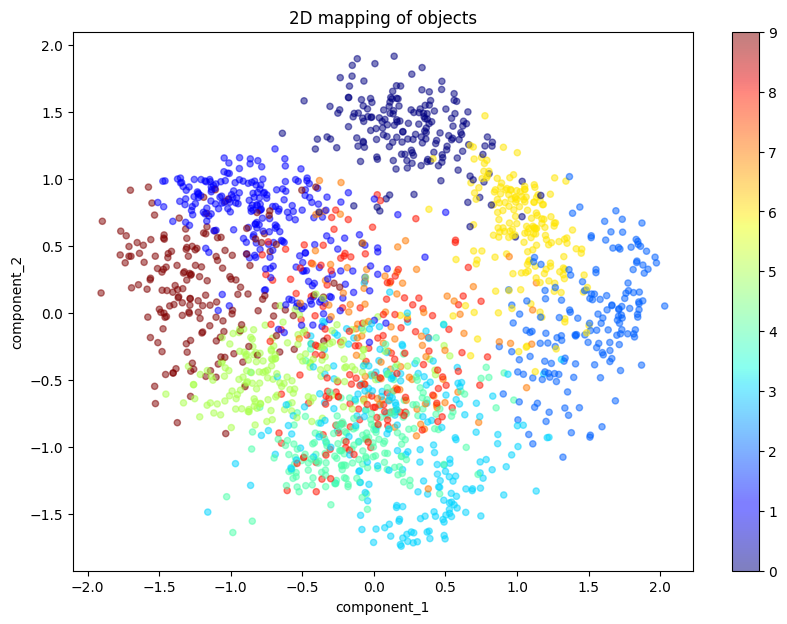

In [ ]:
display_components_in_2D_space(components_X_reduced, labels=labels_clast)

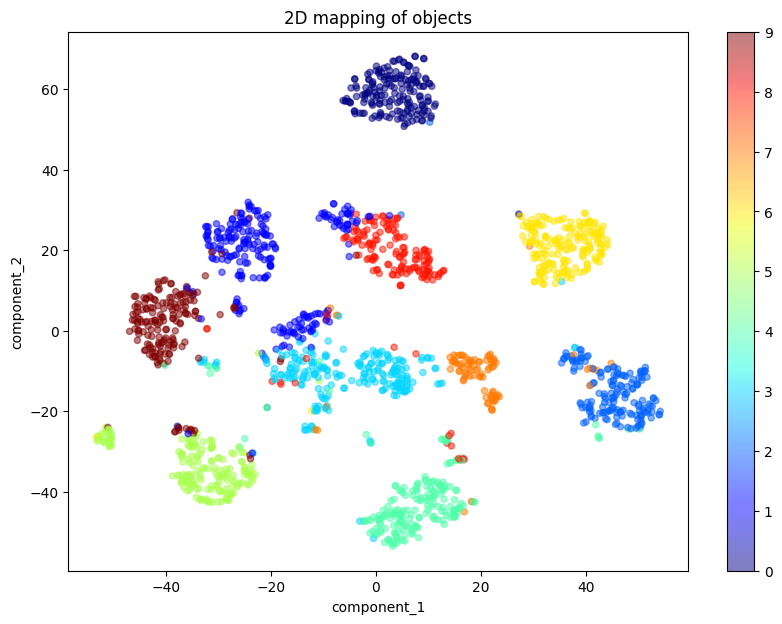

In [ ]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

**DBSCAN**

In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=25)
labels_clast = dbscan.fit_predict(X)
labels_clast = pd.Series(labels_clast)

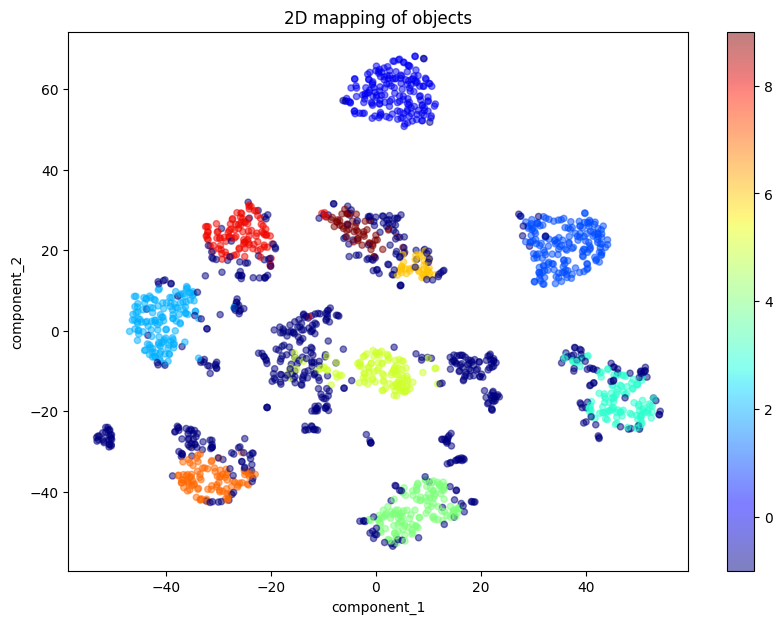

In [ ]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

**AgglomerativeClustering**

In [ ]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

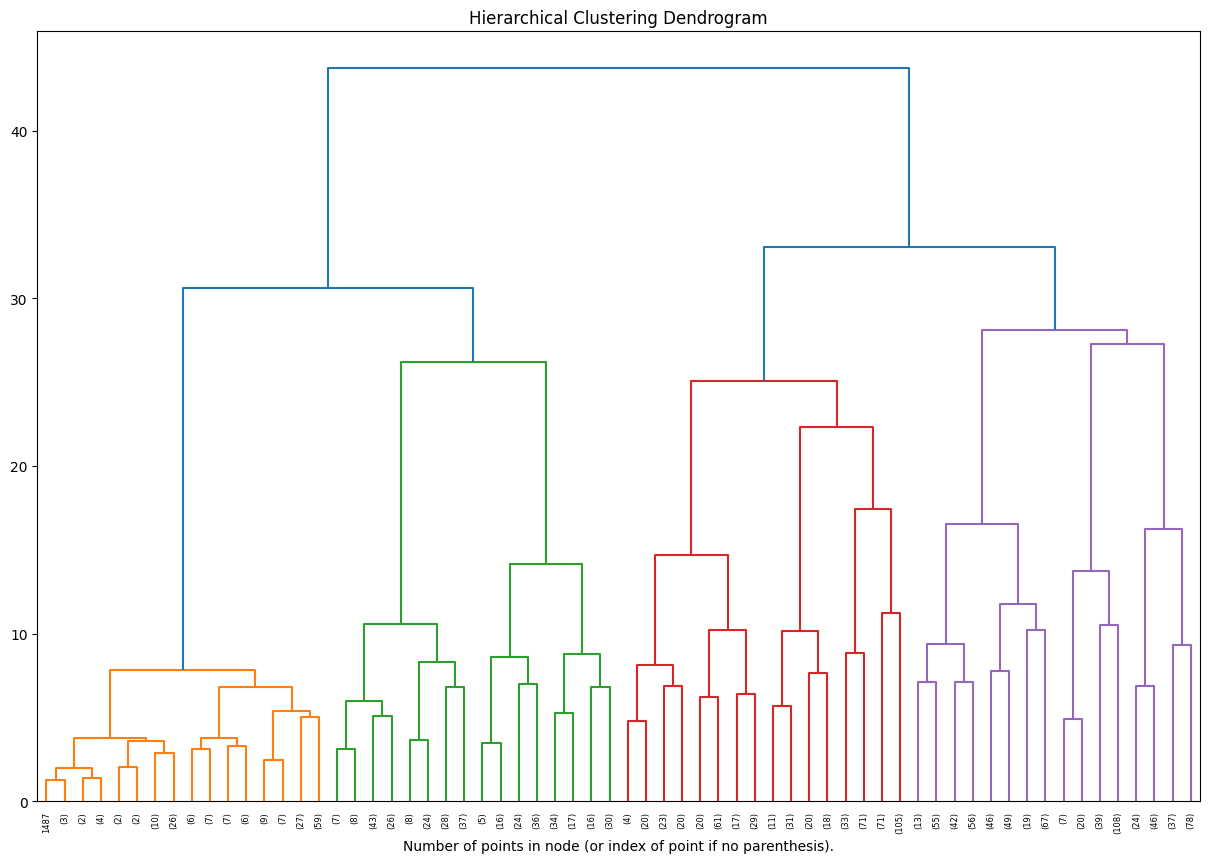

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram

plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
%%time
aggl = AgglomerativeClustering(n_clusters=11)
labels_clast = aggl.fit_predict(X)
labels_clast = pd.Series(labels_clast)

CPU times: user 164 ms, sys: 8.88 ms, total: 173 ms
Wall time: 177 ms


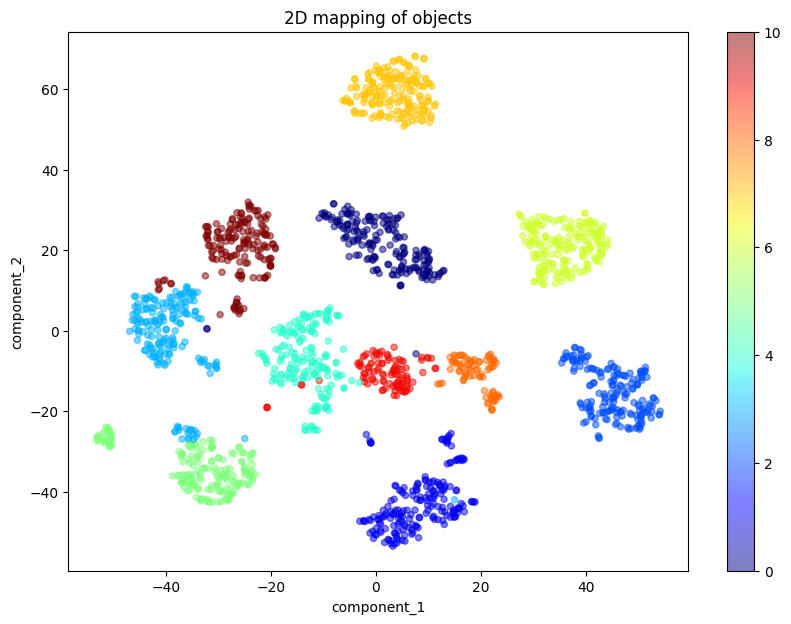

In [ ]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

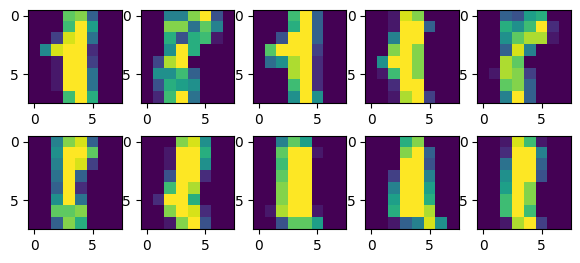

In [ ]:
plt.figure(figsize=(7, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[labels_clast == 9][i,:].reshape([8,8]))

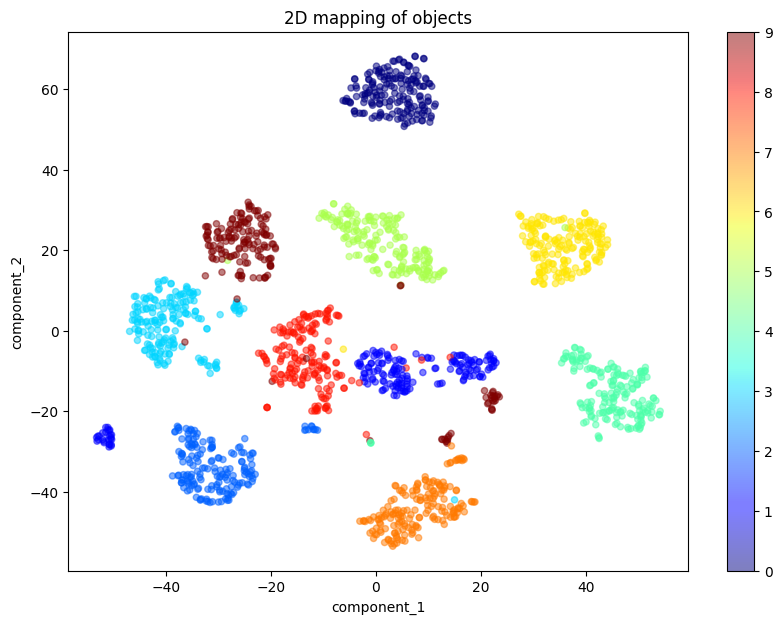

In [ ]:
display_components_in_2D_space(components_X_tsne, labels=y)

## Дополнительные материалы
1.	Документация sklearn по кластеризации
http://scikit-learn.org/stable/modules/clustering.html
2. Метрики sklearn для задачкластеризации http://scikit-learn.org/stable/modules/classes.html
2. Open Data Science, habrahabr: Обучение без  учителя: PCA и кластеризация https://habrahabr.ru/company/ods/blog/325654/
3. Книжка https://cs7053.userapi.com/c812420/u4462765/docs/dbe264335e79/Introduction_to_ML_with_Python.pdf?extra=8V6L6yO8guwpde_XiD-plCoabKpDglwlaUl6TPHwVJ6bd-WBp5biUDb8PvXT8FsNoQcnMzcuYRd6qWKowntRuZ5fy3C4TkbgooCom26ARKvwTztOtZQvqQ&dl=1
4. Модель KMeans https://youtu.be/EHZJMz6zyFE
5. Метод локтя https://youtu.be/BEhLlqkL-f4
